# REASSEMBLING OF JUMBLED IMAGES USING DEEP LEARNING</p> MLWARE - MACHINE LEARNING HACKATHON UNDER TECHNEX, IIT BHU
## LINK TO KAGGLE COMPETITION:</br> https://www.kaggle.com/competitions/mlware23/ </p>TEAM - Team SHAG </br>
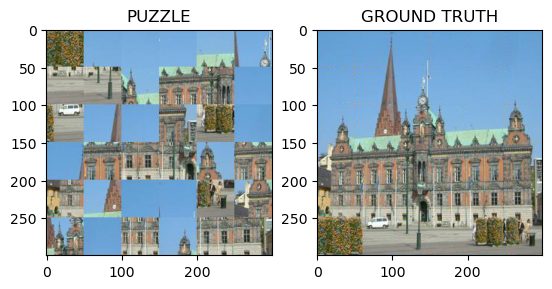 



In [28]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
import cv2

In [29]:
# To ensure that all the columns are read as string
dt = {}
for i in range(6):
    for j in range(6):
        dt[str(i)+str(j)] = str
labels_df = pd.read_csv("/kaggle/input/mlware23/dataset/train/train_landmarks.csv", dtype = dt)

## PREPARING LANDMARK IMAGES

### INFERING FROM GROUND TRUTH DATAFRAME
The Ground Truth CSVs have a total of 37 Columns. First Column is image which acts as a Unique Identifier of each image and is same as Image Name. Rest of the 36 Columns are of the form ij where i and j range from 0 to 5, each of these columns represent the coordinate (i,j). The value of each sample at these columns is also of form ij and each of these values represent the true coordinate of the puzzle piece placed at the coordinate represented by respective column. So if a sample has value 01 under the column 23, it means that the puzzle piece in 1st row and 2nd column should ideally be placed at 3rd row and 4th column (note the 0 based indexing).

In [30]:
labels_df

image  00  01  02  03  04  05  10  11  12  ...  42  43  44  45  \
0     AAHRMrGn0B.jpg  00  35  30  52  15  45  04  05  14  ...  55  03  33  43   
1     jpEcMy3zDs.jpg  42  34  51  32  13  33  04  10  12  ...  40  22  05  43   
2     uyDprath60.jpg  50  15  14  13  24  12  53  52  23  ...  00  02  55  30   
3     k4WEXM5f7C.jpg  21  45  53  20  34  52  15  11  54  ...  50  02  42  41   
4     lG9bsx1nKj.jpg  12  51  01  13  33  15  20  10  22  ...  24  34  25  14   
...              ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
2995  SV1HNRIhCA.jpg  21  53  43  11  22  35  34  23  31  ...  50  51  52  12   
2996  ugvlnYiLBg.jpg  23  55  30  00  03  14  24  32  42  ...  54  13  10  22   
2997  nPBIhjYvNc.jpg  42  24  22  12  35  50  34  51  04  ...  10  00  03  32   
2998  OblPYYJRrw.jpg  45  24  31  41  35  00  44  11  13  ...  22  04  01  14   
2999  cKocuc83vr.jpg  20  02  50  03  23  14  35  54  33  ...  10  22  32  00   

      50  51  52  53  54  55  
0     41  50  31  34  21  11  
1     23  14  41  21  52  35  
2     22  05  41  20  43  45  
3     14  43  40  32  25  44  
4     55  44  30  23  35  52  
...   ..  ..  ..  ..  ..  ..  
2995  32  04  02  33  41  55  
2996  02  50  31  43  53  33  
2997  40  05  44  25  43  20  
2998  03  52  53  25  33  42  
2999  40  55  45  44  01  41  

[3000 rows x 37 columns]

In [31]:
# Train Test Split

n1 = len(labels_df)
val_split = 0.2
val_landmark_df = labels_df[:int(n1*val_split)]
train_landmark_df =labels_df[int(n1*val_split):]

In [32]:
'''
MAKING A FUNCTION THAT TAKES A DATAFRAME OF LABELS AS INPUT AND 
RETURNS ALL THE IMAGES CUT INTO 36 PIECES, THAT IS OF (36, 50, 50, 3) SHAPE IMAGES
'''

def make_landmark_images(df):
    ret = [] # Collectiong all the images (36, 50, 50,3)
    for idx in tqdm(df.index):
        pieces = [] # Collectiong all the pieces (50, 50, 3)
        img_name = df.loc[idx, "image"]
        img = Image.open("/kaggle/input/mlware23/dataset/train/landmarks/" + img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50]) # Using array slicing to extract the pieces
        ret.append(pieces)
    return np.array(ret)


train_landmark_images = make_landmark_images(train_landmark_df)
val_landmark_images = make_landmark_images(val_landmark_df)

100%|██████████| 600/600 [00:01<00:00, 447.95it/s]


In [33]:
'''
A FUNCTION TO REARRANGE THE PUZZLE PIECES TO THEIR RIGHT POSITION
'''

def rearrange_landmarks(df, idx):
    img_name = df.loc[idx, "image"]
    im = Image.open("../input/mlware23/dataset/train/landmarks/" + img_name)
    im = np.array(im)
    new_im = np.zeros_like(im)
    cut = im.shape[0]//6
    for i in range(6):
        for j in range(6):
            r, c = int(df.loc[idx, str(i)+str(j)][0]), int(df.loc[idx, str(i)+str(j)][1])
            new_im[r*cut:(r+1)*cut, c*cut:(c+1)*cut] = im[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
    return im, new_im

Text(0.5, 1.0, 'GROUND TRUTH')

<Figure size 640x480 with 0 Axes>

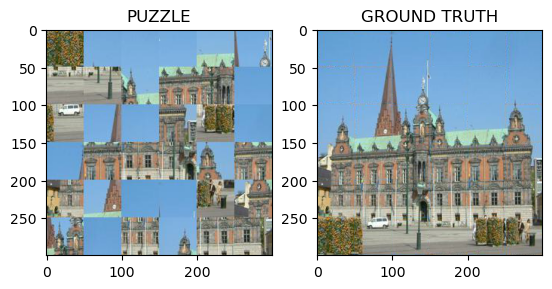

In [34]:
## A SAMPLE PUZZLE IMAGE AND THE GROUND TRUTH
puzzle, solved = rearrange_landmarks(labels_df, 2)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(puzzle)
axarr[0].set_title("PUZZLE")
axarr[1].imshow(solved)
axarr[1].set_title("GROUND TRUTH")

In [35]:
'''
A FUNCTION THAT RETURNS ONE HOT ENCODED LABELS FOR EACH IMAGE, THAT IS OF (36,36) SHAPE.
'''
def load_labels(df):
    ret = []
    for idx in tqdm(df.index):
        label = np.zeros(shape=(36,36))
        for i in range(6):
            for j in range(6):
                place = i*6 + j
                val = int(df.loc[idx, str(i)+str(j)][0])*6 + int(df.loc[idx, str(i)+str(j)][1])
                label[place][val] = 1
        ret.append(label)
    return np.array(ret)

train_landmark_labels = load_labels(train_landmark_df)
val_landmark_labels = load_labels(val_landmark_df)

100%|██████████| 600/600 [00:00<00:00, 1354.25it/s]


In [36]:
# CHECKING THE SHAPES OF OUR TRAIN AND TEST SETS
train_landmark_images.shape, train_landmark_labels.shape, val_landmark_images.shape, val_landmark_labels.shape

((2400, 36, 50, 50, 3), (2400, 36, 36), (600, 36, 50, 50, 3), (600, 36, 36))

### MODEL ARCHITECTURE - LANDMARK

In [37]:
inp = tf.keras.layers.Input(shape=(36,50,50,3)) #input all puzzle pieces at once

#here we only define the layers and feed the input later
conv1 = tf.keras.layers.Conv2D(50, (5,5), strides=2,padding='same')
bn1 = tf.keras.layers.BatchNormalization()
relu1 = tf.keras.layers.Activation('relu')
drop1 = tf.keras.layers.Dropout(rate=0.1)

conv2 = tf.keras.layers.Conv2D(75, (3,3), strides=3,padding='same')
bn2 = tf.keras.layers.BatchNormalization()
relu2 = tf.keras.layers.Activation('relu')
drop2 = tf.keras.layers.Dropout(rate=0.1)

conv3 = tf.keras.layers.Conv2D(100, (3,3), strides=3,padding='same')
bn3 = tf.keras.layers.BatchNormalization()
relu3 = tf.keras.layers.Activation('relu')
drop3 = tf.keras.layers.Dropout(rate=0.1)

flat = tf.keras.layers.Flatten()
dense2 = tf.keras.layers.Dense(200)
dense3 = tf.keras.layers.Dense(200)
dense1 = tf.keras.layers.Dense(36)


#now we feed each puzzle piece one by one to the layers and store the encodings
mid = []
for i in range(36):
    x = conv1(inp[:,i]) #first dimension is batch_size
    x = bn1(x)
    x = relu1(x)
    x = drop1(x)
    
    x = conv2(x)
    x = bn2(x)
    x = relu2(x)
    x = drop2(x)
    
    x = conv3(x)
    x = bn3(x)
    x = relu3(x)
    x = drop3(x)
    
    x = flat(x)
    x = dense2(x)
    x = dense3(x)
    x = dense1(x)
    mid.append(x)


x = tf.keras.layers.concatenate(mid, axis=-1) #the encodings of all the pieces are concatenated
x = tf.keras.layers.Reshape((36,36))(x) #the output is reshaped into a 36x36 output
x = tf.keras.layers.Softmax(axis=-1)(x) #softmax to calculate probability 



In [38]:
model = tf.keras.Model(inputs=inp, outputs=x)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam()
             )

In [175]:
# MAKING A CHECKPOINTER TO SAVE THE BEST WEIGHTS FOR OUR MODEL
checkpointer = tf.keras.callbacks.ModelCheckpoint('Landmark_Weights.h5', verbose=1, save_best_only=True)
model.fit(train_landmark_images,
         train_landmark_labels,
         epochs = 50,
         batch_size=16,
         validation_data = [val_landmark_images, val_landmark_labels],
         callbacks = checkpointer
         )

Epoch 1/25


2023-03-09 11:51:44.244898: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_25/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - ETA: 0s - loss: 3.4678
Epoch 1: val_loss improved from inf to 3.35383, saving model to BestWeights_landmark.h5
300/300 [==============================] - 35s 67ms/step - loss: 3.4678 - val_loss: 3.3538
Epoch 2/25
300/300 [==============================] - ETA: 0s - loss: 3.3671
Epoch 2: val_loss improved from 3.35383 to 3.34140, saving model to BestWeights_landmark.h5
300/300 [==============================] - 18s 58ms/step - loss: 3.3671 - val_loss: 3.3414
Epoch 3/25
300/300 [==============================] - ETA: 0s - loss: 3.3332
Epoch 3: val_loss improved from 3.34140 to 3.29713, saving model to BestWeights_landmark.h5
300/300 [==============================] - 18s 59ms/step - loss: 3.3332 - val_loss: 3.2971
Epoch 4/25
300/300 [==============================] - ETA: 0s - loss: 3.3133
Epoch 4: val_loss improved from 3.29713 to 3.29392, saving model to BestWeights_landmark.h5
300/300 [==============================] - 17s 57ms/step - loss: 3

In [40]:
# LOADING OUR BEST WEIGHTS
loaded_model = tf.keras.Model(inputs = inp, outputs = x)
loaded_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam()
                    )

In [41]:
loaded_model.load_weights("/kaggle/working/Landmark_Weights.h5")

In [42]:
# PREPARING THE TEST SET
test_landmark_list = os.listdir("/kaggle/input/mlware23/dataset/test/landmarks")
test_landmark_df = pd.DataFrame({"image":test_landmark_list})
test_landmark_df

image
0     KAaYWOONwc.jpg
1     Jn0mEtt6ru.jpg
2     ej6bggtV8J.jpg
3     ulozGUHcHq.jpg
4     dqqUqsVIT9.jpg
...              ...
1091  LtSWXrsNf9.jpg
1092  u7hsNtpX0P.jpg
1093  bPnwug5C6l.jpg
1094  lzz6bPFDjZ.jpg
1095  DHCBHTt06Q.jpg

[1096 rows x 1 columns]

In [44]:
'''
DEFINING A FUNCTION THAT RETURN WITH TEST IMAGES OF LANDMARKS
'''

def make_landmark_test_images(df):
    ret = []
    for idx in tqdm(df.index):
        pieces = []
        img_name = df.loc[idx, "image"]
        img = Image.open("/kaggle/input/mlware23/dataset/test/landmarks/" + img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)


test_landmark_images = make_landmark_test_images(test_landmark_df)

100%|██████████| 1096/1096 [00:02<00:00, 448.04it/s]


In [135]:
# MAKING PREDICTION ON THE TEST SET
pred = loaded_model.predict(test_landmark_images)
pred = np.argmax(pred, axis=-1)

35/35 [==============================] - 1s 26ms/step


In [136]:
# MAKING A DATAFRAME OF OUR PREDICTIONS
pred_list = []
for i in range(pred.shape[0]):
    t = []
    for j in range(pred[i].shape[0]):
        t.append(str(pred[i][j]//6) + str(pred[i][j]%6))
    pred_list.append(t)

image_df = pd.DataFrame(test_landmark_df["image"])
label_df = pd.DataFrame(pred_list)
out = pd.concat([image_df, label_df], axis=1)
out.columns = labels_df.columns
out

image  00  01  02  03  04  05  10  11  12  ...  42  43  44  45  \
0     KAaYWOONwc.jpg  12  35  25  23  32  12  12  14  31  ...  22  53  20  32   
1     Jn0mEtt6ru.jpg  21  43  31  02  22  53  50  33  04  ...  33  50  50  41   
2     ej6bggtV8J.jpg  24  55  52  25  35  30  52  04  55  ...  20  20  20  55   
3     ulozGUHcHq.jpg  21  13  34  21  32  32  45  41  11  ...  14  04  04  40   
4     dqqUqsVIT9.jpg  45  44  40  30  44  22  15  01  34  ...  21  55  13  53   
...              ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
1091  LtSWXrsNf9.jpg  04  20  31  13  50  03  42  04  44  ...  04  42  04  54   
1092  u7hsNtpX0P.jpg  45  55  55  41  55  33  55  55  55  ...  45  51  42  55   
1093  bPnwug5C6l.jpg  53  50  53  42  14  42  34  33  52  ...  34  51  52  31   
1094  lzz6bPFDjZ.jpg  42  50  53  05  22  10  41  53  51  ...  53  53  53  20   
1095  DHCBHTt06Q.jpg  45  04  55  04  30  53  52  10  04  ...  12  01  50  50   

      50  51  52  53  54  55  
0     22  13  20  42  22  05  
1     50  04  34  33  24  53  
2     35  03  45  04  42  00  
3     14  33  13  42  42  04  
4     55  32  41  02  32  14  
...   ..  ..  ..  ..  ..  ..  
1091  32  23  42  04  45  03  
1092  32  55  55  45  55  30  
1093  21  41  34  10  23  40  
1094  52  53  20  10  53  53  
1095  51  14  11  52  54  50  

[1096 rows x 37 columns]

In [137]:
'''
A FUNCTION TO REARRANGE THE TEST IMAGES GIVEN ITS LABELS THROUGH A DATAFRAME
'''

def rearrange_landmark_test(df, idx):
    img_name = df.loc[idx, "image"]
    im = Image.open("../input/mlware23/dataset/test/landmarks/" + img_name)
    im = np.array(im)
    new_im = np.zeros_like(im)
    cut = im.shape[0]//6
    for i in range(6):
        for j in range(6):
            r, c = int(df.loc[idx, str(i)+str(j)][0]), int(df.loc[idx, str(i)+str(j)][1])
            new_im[r*cut:(r+1)*cut, c*cut:(c+1)*cut] = im[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
    return im, new_im

In [138]:
images = []
new_images = []
# TAKING RANDOM SAMPLES FROM OUR TEST SET
a = [249,5,145,78,22,456,528,745,645,32]
for i in tqdm(a):
    image, new_image = rearrange_landmark_test(out, i)
    images.append(image)
    new_images.append(new_image)

100%|██████████| 10/10 [00:00<00:00, 281.21it/s]


## VISUALISING OUR PREDICTIONS ON LANDMARK IMAGES

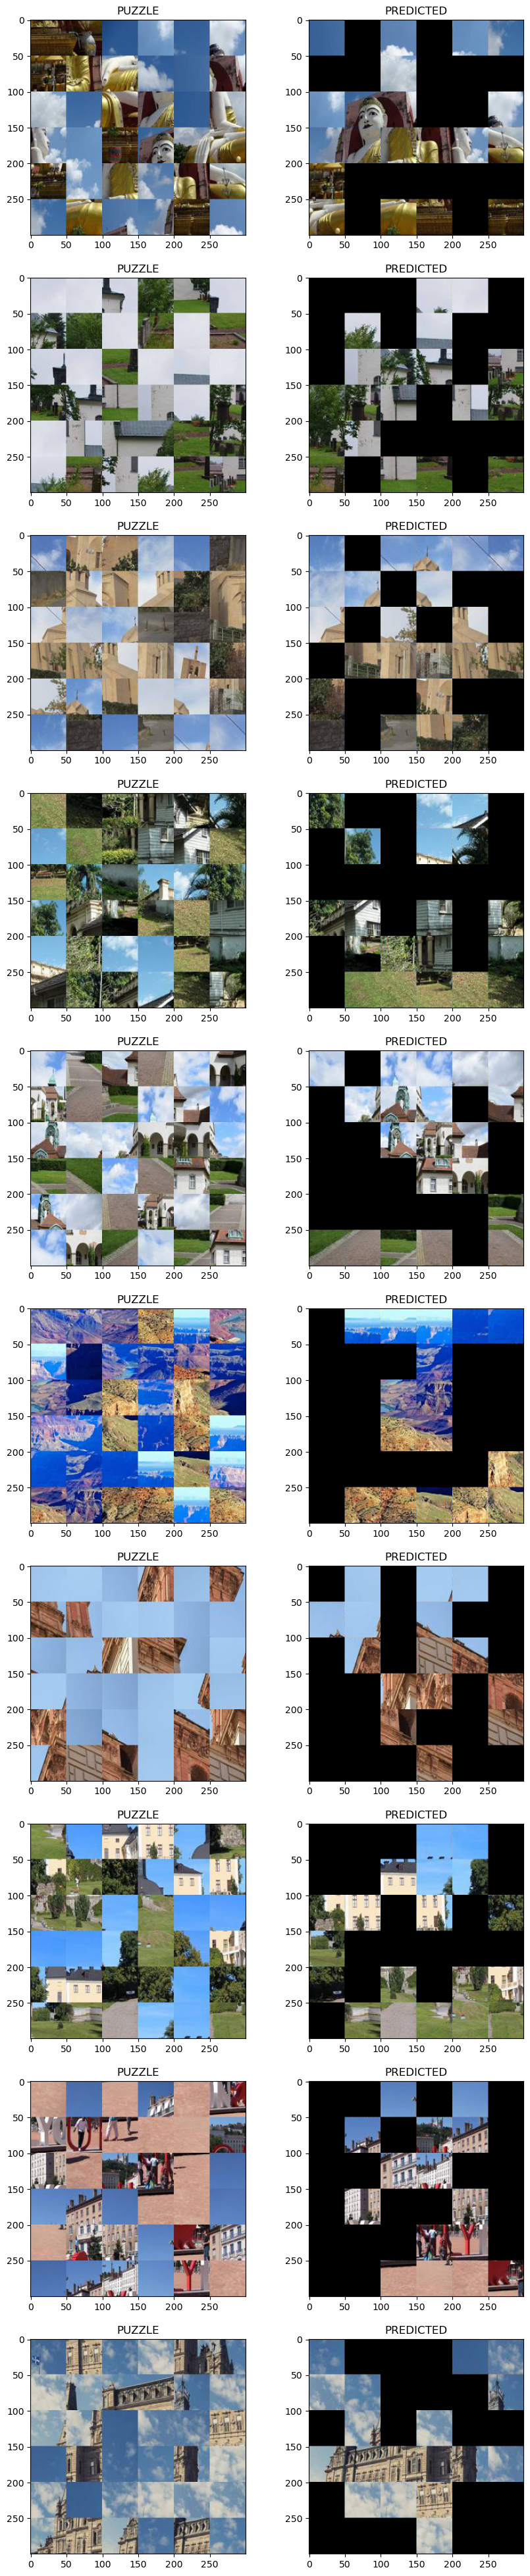

In [139]:
fig, ax = plt.subplots(10,2, figsize = (10,50))
for i in range(0,10):
    ax[i][0].imshow(images[i])
    ax[i][0].set_title("PUZZLE")
    ax[i][1].imshow(new_images[i])
    ax[i][1].set_title("PREDICTED")

In [92]:
'''
A FUNCTION TO CONVERT OURE PREDICTION TO SUBMISSION FORMAT
'''
def prediction_to_submission(df):
    df = df.copy()
    for s in ['r','c']:
        for i in range(6):
            for j in range(6):
                df[str(s)+str(i)+str(j)] = None

    for idx in df.index:
        for i in range(6):
            for j in range(6):
                df.loc[idx, 'r'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][0])
                df.loc[idx, 'c'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][1])

    columns_to_remove = []
    for i in range(6):
        for j in range(6):
            columns_to_remove.append(str(i)+str(j))

    return df.drop(columns=columns_to_remove)

submission1 = prediction_to_submission(out)
submission1

image r00 r01 r02 r03 r04 r05 r10 r11 r12  ... c42 c43 c44 c45  \
0     KAaYWOONwc.jpg   1   3   2   2   3   1   1   1   3  ...   2   3   0   2   
1     Jn0mEtt6ru.jpg   2   4   3   0   2   5   5   3   0  ...   3   0   0   1   
2     ej6bggtV8J.jpg   2   5   5   2   3   3   5   0   5  ...   0   0   0   5   
3     ulozGUHcHq.jpg   2   1   3   2   3   3   4   4   1  ...   4   4   4   0   
4     dqqUqsVIT9.jpg   4   4   4   3   4   2   1   0   3  ...   1   5   3   3   
...              ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
1091  LtSWXrsNf9.jpg   0   2   3   1   5   0   4   0   4  ...   4   2   4   4   
1092  u7hsNtpX0P.jpg   4   5   5   4   5   3   5   5   5  ...   5   1   2   5   
1093  bPnwug5C6l.jpg   5   5   5   4   1   4   3   3   5  ...   4   1   2   1   
1094  lzz6bPFDjZ.jpg   4   5   5   0   2   1   4   5   5  ...   3   3   3   0   
1095  DHCBHTt06Q.jpg   4   0   5   0   3   5   5   1   0  ...   2   1   0   0   

     c50 c51 c52 c53 c54 c55  
0      2   3   0   2   2   5  
1      0   4   4   3   4   3  
2      5   3   5   4   2   0  
3      4   3   3   2   2   4  
4      5   2   1   2   2   4  
...   ..  ..  ..  ..  ..  ..  
1091   2   3   2   4   5   3  
1092   2   5   5   5   5   0  
1093   1   1   4   0   3   0  
1094   2   3   0   0   3   3  
1095   1   4   1   2   4   0  

[1096 rows x 73 columns]

## FACES IMAGES

In [143]:
face_df = pd.read_csv("/kaggle/input/mlware23/dataset/train/train_faces.csv", dtype = dt)
face_df

image  00  01  02  03  04  05  10  11  12  ...  42  43  44  45  \
0   hwJUKjziH0.jpg  22  20  14  04  43  40  35  53  25  ...  31  41  13  32   
1   smzyIVQ4Ve.jpg  03  50  43  14  05  13  33  52  01  ...  41  35  45  30   
2   IT3H2QbaJY.jpg  55  25  43  10  33  20  22  13  54  ...  00  42  11  41   
3   Yceag6Ca0B.jpg  12  32  52  05  15  42  55  04  10  ...  34  20  13  21   
4   nDBcp5ZyPj.jpg  33  44  12  45  50  54  20  24  00  ...  55  34  04  25   
..             ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
94  18JgpkiDOL.jpg  04  42  34  33  00  01  20  03  30  ...  02  21  31  05   
95  oSpFCAFQwT.jpg  41  04  03  33  24  42  00  40  34  ...  55  23  05  11   
96  DXsAm4YNMB.jpg  35  00  33  52  21  23  11  15  30  ...  42  31  55  01   
97  3HP9T1V8oW.jpg  50  23  22  13  55  43  10  34  45  ...  25  40  41  30   
98  SiANxfuaTb.jpg  45  31  15  12  05  54  11  41  14  ...  32  34  01  02   

    50  51  52  53  54  55  
0   33  10  02  30  50  44  
1   44  22  51  00  32  15  
2   12  23  30  51  35  32  
3   22  45  33  41  23  35  
4   52  15  11  21  02  32  
..  ..  ..  ..  ..  ..  ..  
94  10  23  52  40  43  25  
95  50  54  15  44  35  10  
96  45  13  24  53  43  34  
97  52  04  42  44  53  54  
98  43  22  44  33  55  30  

[99 rows x 37 columns]

In [87]:
# Train Test Split
n2 = len(face_df)
val_split = 0.15
val_face_df = face_df[:int(n2*val_split)]
train_face_df =face_df[int(n2*val_split):]

## PREPARING FACE IMAGES

In [89]:
def make_face_images(df):
    ret = []
    for idx in tqdm(df.index):
        pieces = []
        img_name = df.loc[idx, "image"]
        img = Image.open("/kaggle/input/mlware23/dataset/train/faces/"+img_name)
        img = np.array(img)
#         img = img/255.0
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

train_face_images = make_face_images(train_face_df)
val_face_images = make_face_images(val_face_df)

100%|██████████| 14/14 [00:00<00:00, 492.53it/s]


In [90]:
#a function to rearrange the puzzle pieces to their right positions
def rearrange_faces(df, idx):
    img_name = df.loc[idx, "image"]
    im = Image.open("../input/mlware23/dataset/train/faces/" + img_name)
    im = np.array(im)
    new_im = np.zeros_like(im)
    cut = im.shape[0]//6
    for i in range(6):
        for j in range(6):
            r, c = int(df.loc[idx, str(i)+str(j)][0]), int(df.loc[idx, str(i)+str(j)][1])
            new_im[r*cut:(r+1)*cut, c*cut:(c+1)*cut] = im[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
    return im, new_im

Text(0.5, 1.0, 'GROUND TRUTH')

<Figure size 640x480 with 0 Axes>

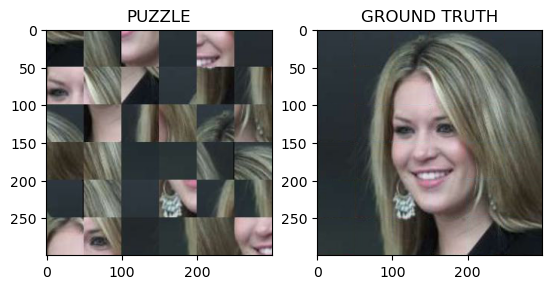

In [91]:
puzzle, solved = rearrange_faces(face_df, 2)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(puzzle)
axarr[0].set_title("PUZZLE")
axarr[1].imshow(solved)
axarr[1].set_title("GROUND TRUTH")

In [93]:
train_face_labels = load_labels(train_face_df)
val_face_labels = load_labels(val_face_df)

100%|██████████| 14/14 [00:00<00:00, 1094.98it/s]


### MODEL ARCHITECTURE - FACES

In [94]:
inp = tf.keras.layers.Input(shape=(36,50,50,3)) #input all puzzle pieces at once

#here we only define the layers and feed the input later
conv1 = tf.keras.layers.Conv2D(30, (7,7), strides=2,padding='same')
bn1 = tf.keras.layers.BatchNormalization()
relu1 = tf.keras.layers.Activation('relu')
drop1 = tf.keras.layers.Dropout(rate=0.1)

conv2 = tf.keras.layers.Conv2D(50, (5,5), strides=3,padding='same')
bn2 = tf.keras.layers.BatchNormalization()
relu2 = tf.keras.layers.Activation('relu')
drop2 = tf.keras.layers.Dropout(rate=0.1)

conv3 = tf.keras.layers.Conv2D(50, (5,5), strides=3,padding='same')
bn3 = tf.keras.layers.BatchNormalization()
relu3 = tf.keras.layers.Activation('relu')
drop3 = tf.keras.layers.Dropout(rate=0.1)

flat = tf.keras.layers.Flatten()
dense2 = tf.keras.layers.Dense(200)
dense3 = tf.keras.layers.Dense(200)
dense1 = tf.keras.layers.Dense(36)


#now we feed each puzzle piece one by one to the layers and store the encodings
mid = []
for i in range(36):
    x = conv1(inp[:,i]) #first dimension is batch_size
    x = bn1(x)
    x = relu1(x)
    x = drop1(x)
    
    x = conv2(x)
    x = bn2(x)
    x = relu2(x)
    x = drop2(x)
    
    x = conv3(x)
    x = bn3(x)
    x = relu3(x)
    x = drop3(x)
    
    x = flat(x)
    x = dense2(x)
    x = dense3(x)
    x = dense1(x)
    mid.append(x)


x = tf.keras.layers.concatenate(mid, axis=-1) #the encodings of all the pieces are concatenated
x = tf.keras.layers.Reshape((36,36))(x) #the output is reshaped into a 36x36 output
x = tf.keras.layers.Softmax(axis=-1)(x) #softmax to calculate probability 


In [ ]:
model2 = tf.keras.Model(inputs=inp, outputs=x)
model2.compile(optimizer="adam", loss="categorical_crossentropy")

In [147]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Face_weights.h5', verbose=1, save_best_only=True)

model2.fit(x=train_face_images, 
          y=train_face_labels, 
          batch_size=16, 
          validation_data=[val_face_images, val_face_labels],
          epochs=35,
          callbacks=checkpointer)

Epoch 1/35


2023-03-09 11:48:03.088008: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_23/dropout_37/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6/6 [==============================] - ETA: 0s - loss: 3.9142
Epoch 1: val_loss improved from inf to 3.50728, saving model to BestWeights_face.h5
6/6 [==============================] - 16s 598ms/step - loss: 3.9142 - val_loss: 3.5073
Epoch 2/35
6/6 [==============================] - ETA: 0s - loss: 3.2951
Epoch 2: val_loss improved from 3.50728 to 3.10590, saving model to BestWeights_face.h5
6/6 [==============================] - 1s 97ms/step - loss: 3.2951 - val_loss: 3.1059
Epoch 3/35
6/6 [==============================] - ETA: 0s - loss: 3.0694
Epoch 3: val_loss did not improve from 3.10590
6/6 [==============================] - 0s 72ms/step - loss: 3.0694 - val_loss: 3.2862
Epoch 4/35
6/6 [==============================] - ETA: 0s - loss: 2.9364
Epoch 4: val_loss improved from 3.10590 to 3.04224, saving model to BestWeights_face.h5
6/6 [==============================] - 0s 86ms/step - loss: 2.9364 - val_loss: 3.0422
Epoch 5/35
6/6 [==============================] - ETA: 0s - loss: 

In [95]:
loaded_model2 = tf.keras.Model(inputs=inp, outputs=x)
loaded_model2.compile(optimizer="adam", loss="categorical_crossentropy")

In [96]:
loaded_model2.load_weights("/kaggle/working/Face_weights.h5")

In [97]:
test_face_list = os.listdir("/kaggle/input/mlware23/dataset/test/faces")
test_face_df = pd.DataFrame({"image":test_face_list})
test_face_df

image
0    WGQXHxMR9O.jpg
1    9U8qCFtbm6.jpg
2    5c226K9FPa.jpg
3    gQZ2RkWph6.jpg
4    CKQKTWgIWM.jpg
..              ...
895  rYaaPLt00W.jpg
896  VdbxsFQx5q.jpg
897  3sRjyN4qMt.jpg
898  KqHjwuLD8a.jpg
899  dFxTTZKbNn.jpg

[900 rows x 1 columns]

In [101]:
def make_test_face_images(df):
    ret = []
    for idx in tqdm(df.index):
        pieces = []
        img_name = df.loc[idx, "image"]
        img = Image.open("/kaggle/input/mlware23/dataset/test/faces/" + img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)


test_face_images = make_test_face_images(test_face_df)

100%|██████████| 900/900 [00:01<00:00, 458.07it/s]


In [102]:
pred2 = loaded_model2.predict(test_face_images)
pred2 = np.argmax(pred2, axis=-1)

29/29 [==============================] - 3s 28ms/step


In [103]:
#formatting our predictions into pandas dataframe
pred_list2 = []
for i in range(pred2.shape[0]):
    t = []
    for j in range(pred2[i].shape[0]):
        t.append(str(pred2[i][j]//6) + str(pred2[i][j]%6))
    pred_list2.append(t)

image_df = pd.DataFrame(test_face_df["image"])
label_df = pd.DataFrame(pred_list2)
out2 = pd.concat([image_df, label_df], axis=1)
out2.columns = labels_df.columns
out2

image  00  01  02  03  04  05  10  11  12  ...  42  43  44  45  \
0    WGQXHxMR9O.jpg  11  33  15  35  13  31  55  54  01  ...  31  15  03  50   
1    9U8qCFtbm6.jpg  15  01  05  05  05  12  05  20  15  ...  42  15  33  23   
2    5c226K9FPa.jpg  50  05  15  23  10  24  10  00  51  ...  15  01  50  13   
3    gQZ2RkWph6.jpg  13  15  51  22  54  54  15  12  50  ...  01  50  14  51   
4    CKQKTWgIWM.jpg  43  53  42  21  44  11  34  01  52  ...  02  13  12  24   
..              ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
895  rYaaPLt00W.jpg  32  05  31  14  05  42  41  44  03  ...  05  24  13  15   
896  VdbxsFQx5q.jpg  12  13  13  05  52  54  33  12  15  ...  13  23  12  22   
897  3sRjyN4qMt.jpg  54  41  15  50  40  04  42  12  00  ...  54  02  44  42   
898  KqHjwuLD8a.jpg  33  21  44  34  31  21  52  05  44  ...  41  05  21  22   
899  dFxTTZKbNn.jpg  21  54  34  44  51  54  05  03  22  ...  34  21  05  23   

     50  51  52  53  54  55  
0    21  42  11  15  12  54  
1    22  24  52  25  30  54  
2    12  43  42  34  31  31  
3    51  31  02  50  43  15  
4    41  02  11  14  35  52  
..   ..  ..  ..  ..  ..  ..  
895  12  43  51  14  43  50  
896  12  34  22  43  24  23  
897  31  34  01  00  22  54  
898  05  42  04  44  34  51  
899  11  05  02  05  34  05  

[900 rows x 37 columns]

In [104]:
def rearrange_test_face(df, idx):
    img_name = df.loc[idx, "image"]
    im = Image.open("../input/mlware23/dataset/test/faces/" + img_name)
    im = np.array(im)
    new_im = np.zeros_like(im)
    cut = im.shape[0]//6
    for i in range(6):
        for j in range(6):
            r, c = int(df.loc[idx, str(i)+str(j)][0]), int(df.loc[idx, str(i)+str(j)][1])
            new_im[r*cut:(r+1)*cut, c*cut:(c+1)*cut] = im[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
    return im, new_im

In [ ]:
puz, rea = rearrange_test_face(out2, i)
fig, ax = plt.subplots(10,2, figsize = (10,50))
ax[i][0].imshow(puz)
ax[i][0].set_title("puzzle")
ax[i][1].imshow(rea)
ax[i][1].set_title("predicted")

## VISUALISING OUR PREDICTION ON TEST IMAGES OF FACES

In [140]:
images = []
new_images = []
a = [23,1,675,887,169,123,576,39,93,349]
for i in tqdm(a):
    image, new_image = rearrange_test_face(out2, i)
    images.append(image)
    new_images.append(new_image)

100%|██████████| 10/10 [00:00<00:00, 204.79it/s]


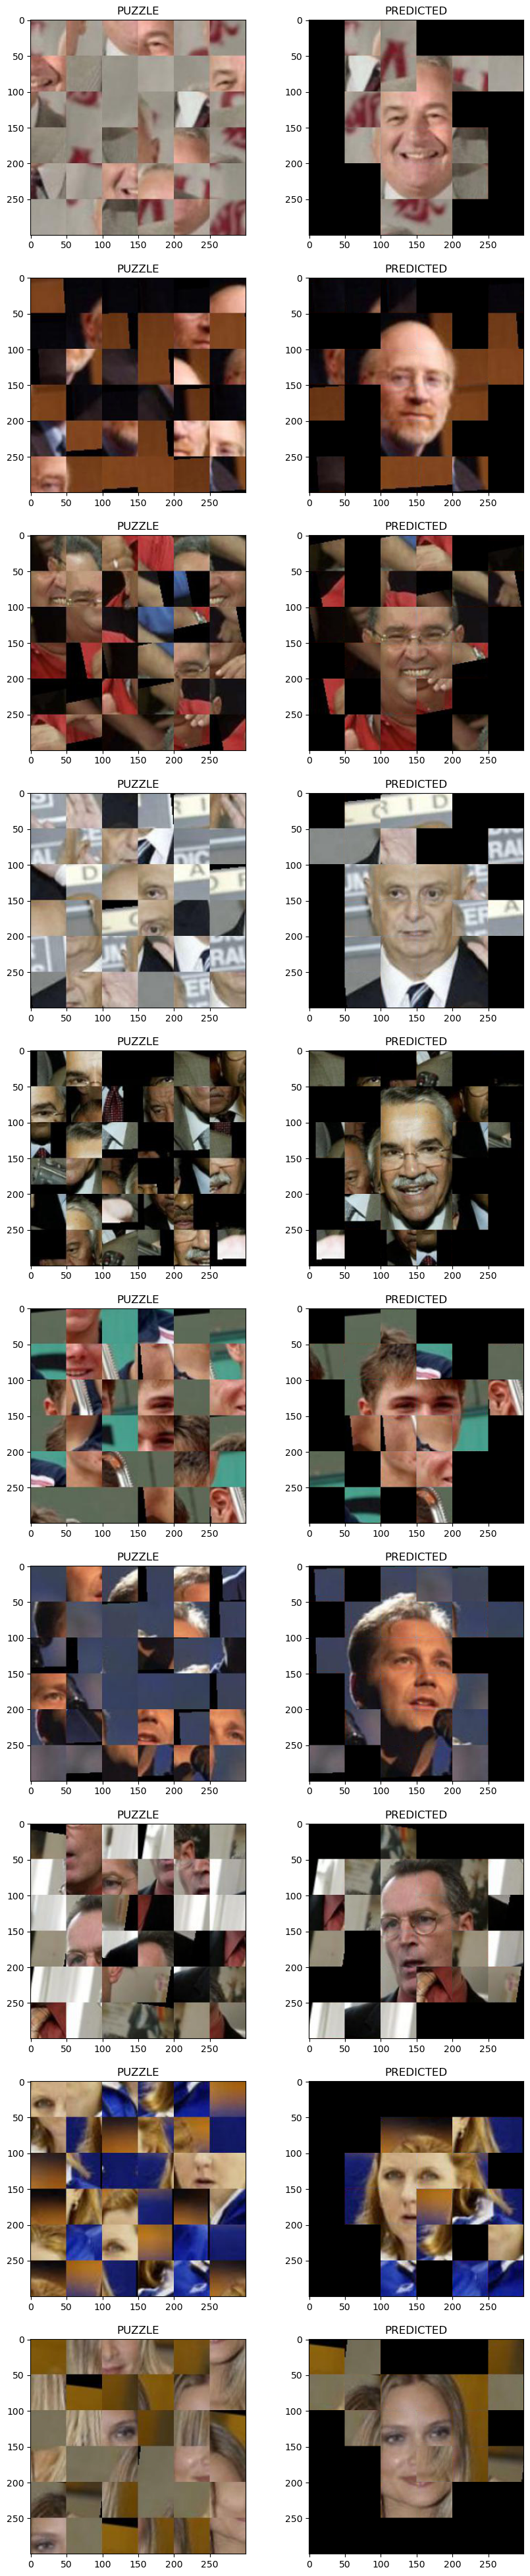

In [141]:
fig, ax = plt.subplots(10,2, figsize = (10,50))
for i in range(0,10):
    ax[i][0].imshow(images[i])
    ax[i][0].set_title("PUZZLE")
    ax[i][1].imshow(new_images[i])
    ax[i][1].set_title("PREDICTED")

In [132]:
def prediction_to_submission(df):
    df = df.copy()
    for s in ['r','c']:
        for i in range(6):
            for j in range(6):
                df[str(s)+str(i)+str(j)] = None

    for idx in df.index:
        for i in range(6):
            for j in range(6):
                df.loc[idx, 'r'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][0])
                df.loc[idx, 'c'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][1])

    columns_to_remove = []
    for i in range(6):
        for j in range(6):
            columns_to_remove.append(str(i)+str(j))

    return df.drop(columns=columns_to_remove)

submission2 = prediction_to_submission(out2)
submission2

image r00 r01 r02 r03 r04 r05 r10 r11 r12  ... c42 c43 c44 c45  \
0    WGQXHxMR9O.jpg   1   3   1   3   1   3   5   5   0  ...   1   5   3   0   
1    9U8qCFtbm6.jpg   1   0   0   0   0   1   0   2   1  ...   2   5   3   3   
2    5c226K9FPa.jpg   5   0   1   2   1   2   1   0   5  ...   5   1   0   3   
3    gQZ2RkWph6.jpg   1   1   5   2   5   5   1   1   5  ...   1   0   4   1   
4    CKQKTWgIWM.jpg   4   5   4   2   4   1   3   0   5  ...   2   3   2   4   
..              ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
895  rYaaPLt00W.jpg   3   0   3   1   0   4   4   4   0  ...   5   4   3   5   
896  VdbxsFQx5q.jpg   1   1   1   0   5   5   3   1   1  ...   3   3   2   2   
897  3sRjyN4qMt.jpg   5   4   1   5   4   0   4   1   0  ...   4   2   4   2   
898  KqHjwuLD8a.jpg   3   2   4   3   3   2   5   0   4  ...   1   5   1   2   
899  dFxTTZKbNn.jpg   2   5   3   4   5   5   0   0   2  ...   4   1   5   3   

    c50 c51 c52 c53 c54 c55  
0     1   2   1   5   2   4  
1     2   4   2   5   0   4  
2     2   3   2   4   1   1  
3     1   1   2   0   3   5  
4     1   2   1   4   5   2  
..   ..  ..  ..  ..  ..  ..  
895   2   3   1   4   3   0  
896   2   4   2   3   4   3  
897   1   4   1   0   2   4  
898   5   2   4   4   4   1  
899   1   5   2   5   4   5  

[900 rows x 73 columns]

In [133]:
final_submission = pd.concat([submission1, submission2])
final_submission.reset_index(inplace=True)
final_submission.drop("index",inplace=True,axis = 1)
final_submission.set_index("image",inplace=True)
final_submission

r00 r01 r02 r03 r04 r05 r10 r11 r12 r13  ... c42 c43 c44 c45  \
image                                                   ...                   
KAaYWOONwc.jpg   1   3   2   2   3   1   1   1   3   0  ...   2   3   0   2   
Jn0mEtt6ru.jpg   2   4   3   0   2   5   5   3   0   4  ...   3   0   0   1   
ej6bggtV8J.jpg   2   5   5   2   3   3   5   0   5   5  ...   0   0   0   5   
ulozGUHcHq.jpg   2   1   3   2   3   3   4   4   1   0  ...   4   4   4   0   
dqqUqsVIT9.jpg   4   4   4   3   4   2   1   0   3   0  ...   1   5   3   3   
...             ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
rYaaPLt00W.jpg   3   0   3   1   0   4   4   4   0   1  ...   5   4   3   5   
VdbxsFQx5q.jpg   1   1   1   0   5   5   3   1   1   3  ...   3   3   2   2   
3sRjyN4qMt.jpg   5   4   1   5   4   0   4   1   0   4  ...   4   2   4   2   
KqHjwuLD8a.jpg   3   2   4   3   3   2   5   0   4   2  ...   1   5   1   2   
dFxTTZKbNn.jpg   2   5   3   4   5   5   0   0   2   0  ...   4   1   5   3   

               c50 c51 c52 c53 c54 c55  
image                                   
KAaYWOONwc.jpg   2   3   0   2   2   5  
Jn0mEtt6ru.jpg   0   4   4   3   4   3  
ej6bggtV8J.jpg   5   3   5   4   2   0  
ulozGUHcHq.jpg   4   3   3   2   2   4  
dqqUqsVIT9.jpg   5   2   1   2   2   4  
...             ..  ..  ..  ..  ..  ..  
rYaaPLt00W.jpg   2   3   1   4   3   0  
VdbxsFQx5q.jpg   2   4   2   3   4   3  
3sRjyN4qMt.jpg   1   4   1   0   2   4  
KqHjwuLD8a.jpg   5   2   4   4   4   1  
dFxTTZKbNn.jpg   1   5   2   5   4   5  

[1996 rows x 72 columns]

In [ ]:
final_submission.to_csv("final_submission.csv")